In [1]:
library(readr)
library(magrittr)
# You should load cnvseqTV with library() like this, but this tutorial doesn't for simplicity
#library(cnvseqTV)
# Instead, just here, we source the code rather than call library. Don't do this :)
source("../R/cnvseqtv.R")

# CNVseq-TV Demo

In this demo, we make a few deletions in chr1 of the banana genome, and then generate reads and bams from these, mapped back to the original banana genome.

First, we need to run two commands. First, we use bedtools to generate a list of genome windows that should be analysed. Second, we run samtools which will parse the BAM files and generate a count of reads from each window. Obviously, you'll need both of these things installed, and you need a samtools version of at least 1.20.

In [21]:
#system("bedtools makewindows -g input/Baxijiao.chr1.fa.fai -w 10000 > tmp/windows.bed")
#system("samtools bedcov -Hjc tmp/windows.bed tmp/bam/*.bam >tmp/window_depths.tsv")
#
# For this demo, we don't actually run that, and instead used a precomputed version at input/window_depths.tsv. If you have the
# required software installed, you can of course uncomment the above and actually run it youself.

We then need to instruct cnvseqTV which comparisons to make, and which sample in each comparison is the control sample.

In [22]:
comparisons = tibble::tribble(
    ~comparison, ~sample, ~testctrl,
    "deleted_vs_control",  "deleted", "test",
    "deleted_vs_control",  "control", "control",
)

Now, we read in the samtools results file, which contains bed-like columns describing each window, and then columns for each sample with the total coverage and read counts.

In [23]:
rawtbl = read_tsv("input/window_depths.tsv") %>%
    dplyr::glimpse()

Rows: 4066 Columns: 9
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): #chrom
dbl (8): start, end, tmp/bam/control.bam_cov, tmp/bam/deleted.bam_cov, tmp/b...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 4,066
Columns: 9
$ `#chrom`                     <chr> "chr01", "chr01", "chr01", "chr01", "chr0…
$ start                        <dbl> 0, 10000, 20000, 30000, 40000, 50000, 600…
$ end                          <dbl> 10000, 20000, 30000, 40000, 50000, 60000,…
$ `tmp/bam/control.bam_cov`    <dbl> 248768, 148426, 148116, 152981, 147101, 1…
$ `tmp/bam/deleted.bam_cov`    <dbl> 261595, 166611, 154273, 137863, 150348, 1…
$ `tmp/bam/inverted.bam_cov`   <dbl> 252625, 155206, 139493, 157081, 141551, 1…
$ `tmp/bam/control.bam_count`  <dbl> 1667, 1005, 1003, 1033, 995, 981, 1021, 9…
$ `tmp/bam/deleted.bam_count`  <dbl> 1755, 1133, 1041, 944, 1023, 997, 1131, 9…
$ `tmp/bam/inverted.bam_count` <dbl> 1699, 1049, 941, 1079, 957, 988, 1030, 10…


This is the main function, in which each comparison in the comparisons table is run on each genome window. The result has one line per window and comparison, and no filtering happens here, so the result is across the whole genome.

In [24]:
wg = calculate_cnvs(rawtbl, comparisons)

In [25]:
head(wg)

chrom,start,end,comparison,control_nreads,control_rpm,control_meanreads,test_nreads,test_rpm,test_meanreads,log2_fc,log2_fc_norm,pvalue
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr01,0,10000,deleted_vs_control,1668,410.4615,999.439,1756,432.1705,999.3141,0.07435392,0.3050548,0.124776683
chr01,10000,20000,deleted_vs_control,1006,247.5565,999.439,1134,279.0896,999.3141,0.17297070,0.4036716,0.003768937
chr01,20000,30000,deleted_vs_control,1004,247.0643,999.439,1042,256.4474,999.3141,0.05377637,0.2844772,0.202424345
chr01,30000,40000,deleted_vs_control,1034,254.4467,999.439,945,232.5747,999.3141,-0.12966959,0.1010313,0.022440131
chr01,40000,50000,deleted_vs_control,996,245.0957,999.439,1024,252.0174,999.3141,0.04017843,0.2708793,0.266825961
chr01,50000,60000,deleted_vs_control,982,241.6506,999.439,998,245.6186,999.3141,0.02349715,0.2541980,0.357908633


In [26]:
hit = cnv_rois(wg)

In [27]:
hit

comparison,chrom,hit_group,start,end,n_windows,control_nreads,control_meanreads,test_nreads,test_meanreads,control_rpm,test_rpm,log2_fc,log2_fc_norm,pvalue
<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
deleted_vs_control,chr01,1,310000,320000,1,1016,999.439,1,999.3141,250.0173,0.2461108,-9.988504,-9.757803,3.388246e-219
deleted_vs_control,chr01,2,1000000,2000000,100,99917,99943.901,163,99931.4068,245.8758,0.4011606,-9.860859,-9.630158,2.596828e-198
deleted_vs_control,chr01,3,3100000,3200000,10,9873,9994.390,10,9993.1407,242.9548,0.2461108,-9.945997,-9.715296,3.495597e-219


# Plotting

Now, we want to plot our results. To start with, we plot the whole genome. In our little test, we use only one comparison on chromosome one. In full datasets this plot will be a matrix of plots, where the multiple samples to be compared will form rows and the multiple chromosomes will form the columns. Note that in all cases, a ggplot object is returned, and further customisation and labelling is possible. Of course, you can also make custom plots of your own, based on the above two tables (`wg` and `hit` in this notebook).

Warning message:
“Using alpha for a discrete variable is not advised.”


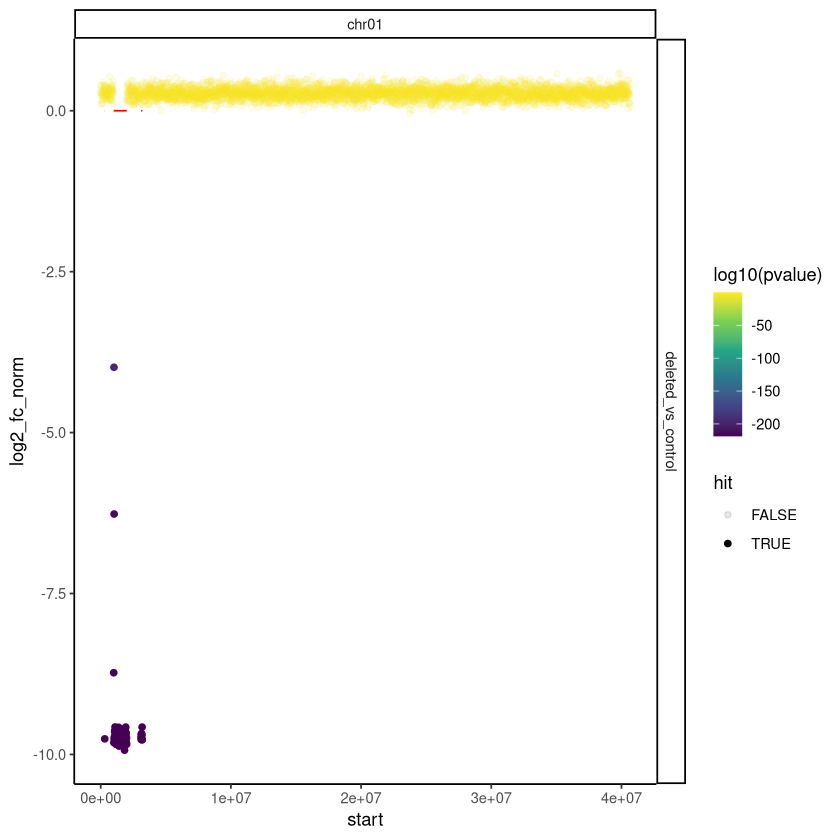

In [28]:
cnv_plot(wg, hit)

And now, we zoom in on each of our three regions of interest. Again, these would form

Warning message:
“Using alpha for a discrete variable is not advised.”


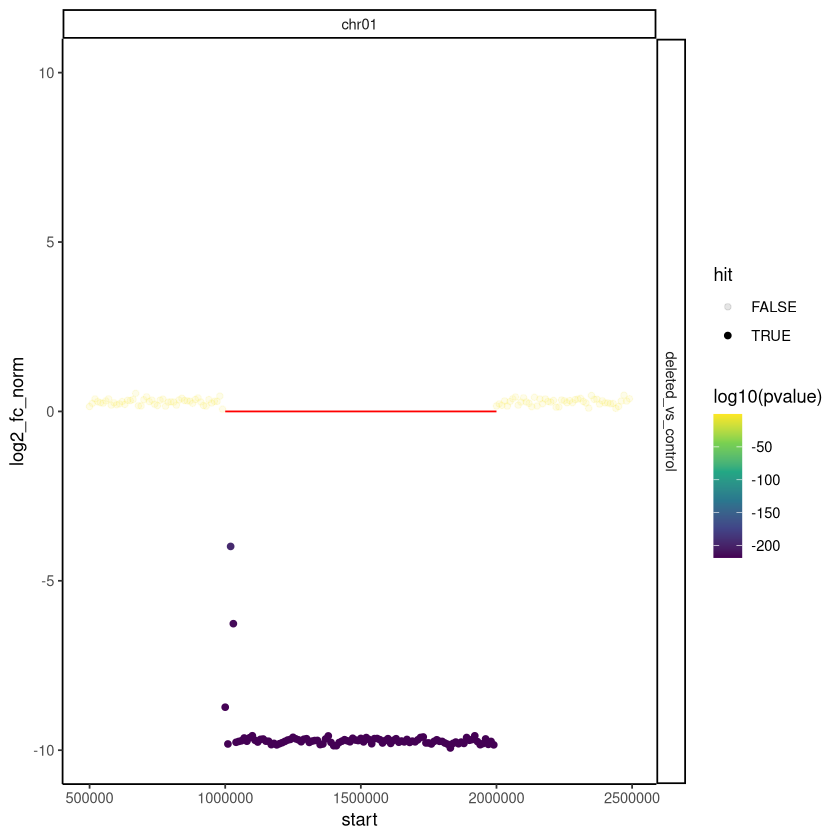

In [29]:
cnv_plot(wg, hit, zoom_chrom="chr01", zoom_start=0.5e6, zoom_end=2.5e6) + ggplot2::ylim(-10, 10)

Warning message:
“Using alpha for a discrete variable is not advised.”


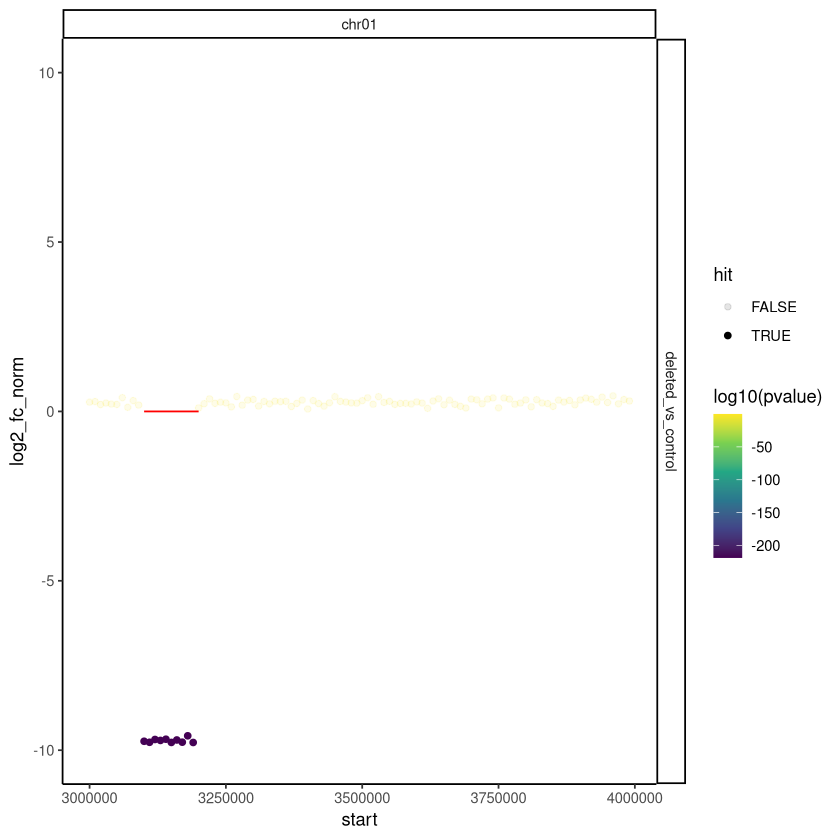

In [30]:
cnv_plot(wg, hit, zoom_chrom="chr01", zoom_start=3e6, zoom_end=4e6) + ggplot2::ylim(-10, 10)


Warning message:
“Using alpha for a discrete variable is not advised.”


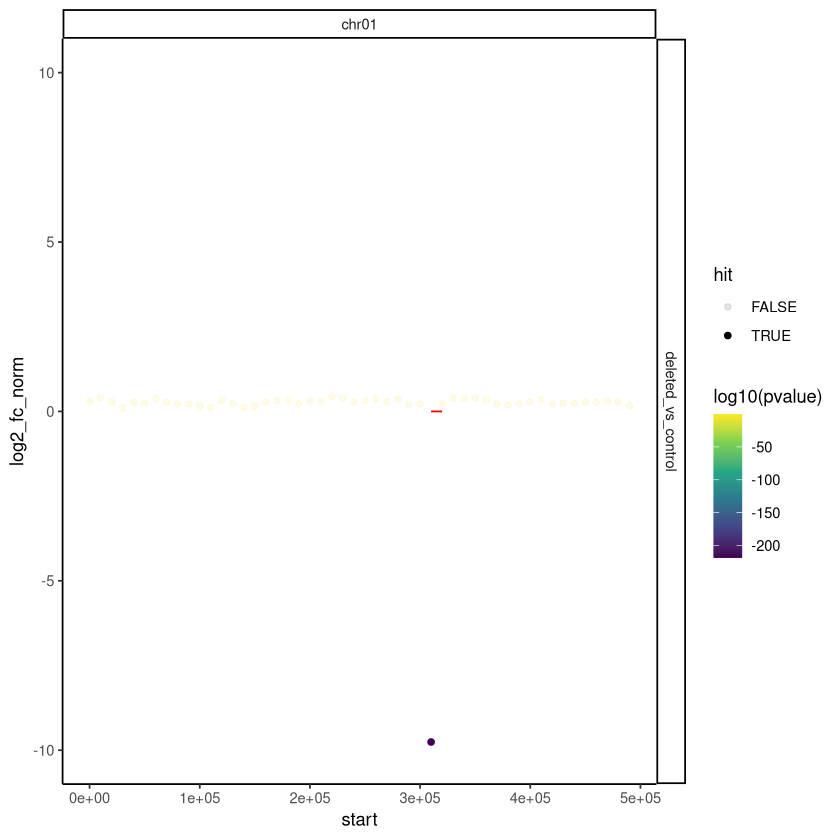

In [31]:
cnv_plot(wg, hit, zoom_chrom="chr01", zoom_end=0.5e6) + ggplot2::ylim(-10, 10)